In [1]:
import requests
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

In [2]:
#сайт для скрапинга
url = 'https://afisha.tut.by/film/'
response = requests.get(url)

In [3]:
#парсим сайт
soup = BeautifulSoup(response.text, 'html.parser')

In [4]:
#получаем лист ссылок всех фильмов
links_list = []
for ultag in soup.find_all('ul', {'class': 'b-lists list_afisha col-5'}):
    for link in ultag.find_all('li', {'class': 'lists__li'}):
        for a_tag in link.find_all('a'):
            links_list.append(a_tag['href'])
#print(links_list)
print(len(links_list))

409


In [5]:
unic_link_list = []
for link in links_list:
    if link not in unic_link_list:
        unic_link_list.append(link)
#print(unic_link_list)
print(len(unic_link_list))

140


In [6]:
for i in range(0,len(unic_link_list)):
    film_url = unic_link_list[i]
    print(i, film_url)

0 https://afisha.tut.by/film/malefisenta-vladychica-tmy/
1 https://afisha.tut.by/film/tekst/
2 https://afisha.tut.by/film/oni/
3 https://afisha.tut.by/film/okey-leksi/
4 https://afisha.tut.by/film/dzhudi-2019/
5 https://afisha.tut.by/film/zombilend-kontrolnyy-vystrel/?utm_source=afisha.tut.by&utm_medium=films&utm_campaign=premiere_block
6 https://afisha.tut.by/film/ditya-pogody/?utm_source=afisha.tut.by&utm_medium=films&utm_campaign=premiere_block
7 https://afisha.tut.by/film/terminator-temnye-sudby/?utm_source=afisha.tut.by&utm_medium=films&utm_campaign=premiere_block
8 https://afisha.tut.by/film/semeyka-addams/?utm_source=afisha.tut.by&utm_medium=films&utm_campaign=premiere_block
9 https://afisha.tut.by/film/urfin-dzhyus-vozvrashchaetsya/?utm_source=afisha.tut.by&utm_medium=films&utm_campaign=premiere_block
10 https://afisha.tut.by/film/proshchanie-2019/
11 https://afisha.tut.by/film/maleficent_mistress_of_evil_ru_sub/
12 https://afisha.tut.by/film/zelenee-travy/
13 https://afisha.tu

In [7]:
films_name = []
films_genre = []
films_age = []
films_year = []
films_author = []
films_producer = []
films_actors = []
films_description = []
films_rate = []

for i in range(0,len(unic_link_list)):
    film_url = unic_link_list[i]
    film_response = requests.get(film_url)
    film_soup = BeautifulSoup(film_response.text, 'html.parser')
    
#название фильма
    try:
        film_name = film_soup.find('h1').string
#        print(i, film_name)
        films_name.append(film_name)
    except:
#        print('Не нашли имя')
        films_name.append('No data')

#жанры фильма
    film_genre = ''
    try:
        for genre in film_soup.find_all('a', {'itemprop': 'genre'}):
            film_genre = film_genre + genre.string + ', '
#        print('     Жанры: ' + film_genre)
        films_genre.append(film_genre)
    except:
#        print('     Не нашли жанр')
        films_genre.append('No data')
    
#возрастное ограничение
    try:
        container = film_soup.find('div',{'class': 'title__labels'})
        if len(container.findAll('span', {'class', 'label'})) != 0:
            if len(container.findAll('span', {'class', 'label'})) == 1:
                 for element in container.findAll('span', {'class', 'label'}):
                    if 'Премьера' not in element.text:
                        films_age.append(container.find('span', {'class', 'label'}).text)
                    else:
                        films_age.append('No data')
            else:
                h = container.findAll('span', {'class', 'label'})[0]
                h.decompose()
                films_age.append(container.find('span', {'class', 'label'}).text)
        else:
            films_age.append('No data')
    except:
        films_age.append('No data')
#год выпуска фильма
    try:
        film_year = film_soup.find('td', {'class': 'year'})
        year = film_year.find('a', recursive = False).text
#        print('     Год выпуска: ' + year)
        films_year.append(year)
    except:
#        print('     Не нашли год')
        films_year.append('No data')

#страна автор фильма
    try:
        film_author = film_soup.find('td', {'class': 'author'})
#        print('     Страна/ы автор/ы: ' + film_author.text)
        films_author.append(film_author.text)
    except:
#        print('     Cтрана не указана')
        films_author.append('No data')
        
#режиссер фильма
    str1 = 'Режиссер: '
    try:
        for p in film_soup.find_all('p'):
            string = p.string
            if string.startswith(str1):    
                film_producer = string[len(str1):]
                break
#        print('     Режиссер: ' + film_producer)
        films_producer.append(film_producer)
    except:
#        print('     Не нашли режиссера')
        films_producer.append('No data')
        
#актеры фильма   
    str2 = 'В ролях: '
    try:
        for p in film_soup.find_all('p'):
            string = p.contents[0]
            tmp_str = string.string
            if tmp_str.find(str2)>-1:
                tag = p
                break
        film_actors = ''
        if len(tag)>1:
            for i in tag:        
                some = i
                try:
                    film_actors = film_actors + some.text
                except:
                    film_actors = film_actors + some.string  
#            print('     Актеры: ' + film_actors[len(str2):])
            film_actors = film_actors[len(str2):]
            films_actors.append(film_actors)
        else:
#            print('     Актеры: ' + i.string[len(str2):])
            films_actors.append(i.string[len(str2):])
    except:
#        print('     Не нашли список акторов')
        films_actors.append('No data')
        
#описание фильма   
    str3 = 'Поделиться:'
    str4 = '.'
    try:
        description = film_soup.find('div',{'itemprop':'description'}).text
        index = description.find(str3, 1,len(description))
        descr1 = description[:index]
        first_word = re.match(r'\W*(\w[^,. !?"]*)', descr1).groups()[0]
        index = descr1.find(first_word, 1,len(descr1))
        descr2 = descr1[index:]
        index = descr2.rfind(str4, 1,len(descr2))
        film_description = descr2[:index+1]
#        print('     Описание: ' + film_description)
        films_description.append(film_description)
    except:
#        print('     Не нашли описание')
        films_description.append('No data')
        
#рейтинг фильма
    try:
        film_rate = film_soup.find('span', {'class': 'rating-big__value'})
        rate = film_rate.text
#        print('     Рейтинг: ' + film_rate)
        films_rate.append(rate)
    except:
#        print('     Не нашли рейтинг')
        films_rate.append('No data')

In [8]:
films = {}
for i in range(0,len(films_name)):
    films[films_name[i]] = {}
    films[films_name[i]]['url'] = unic_link_list[i]
    if len(films_genre[i])< 4:
        film_genre = 'No data'
    else:
        film_genre = films_genre[i][:-2]  
    films[films_name[i]]['genre'] = film_genre
    films[films_name[i]]['year'] = films_year[i]     
    countries = films_author[i]
    if countries == '2019':
        countries = 'No data'
    films[films_name[i]]['author'] = countries.strip().split(', ')
    films[films_name[i]]['producer'] = films_producer[i]
    films[films_name[i]]['actors'] = films_actors[i].split(', ')
    films[films_name[i]]['rating'] = films_rate[i]
    films[films_name[i]]['age'] = films_age[i] 
    films[films_name[i]]['description'] = films_description[i]

In [9]:
spark = SparkSession.builder.appName("pandasToSpark").getOrCreate()
sc = spark.sparkContext

In [22]:
pdDF = pd.DataFrame(films).transpose()
#print(pdDF)
df = spark.createDataFrame(pdDF)

In [12]:
df.show()

+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------+-------+-----------+
|                 url|               genre|   year|              author|            producer|              actors| rating|    age|description|
+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------+-------+-----------+
|https://afisha.tu...|             No data|   2019|               [США]|      Хоаким Роннинг|[Мишель Пфайффер,...|    7,4|No data|    No data|
|https://afisha.tu...|      Драма, Триллер|   2019|            [Россия]|        Клим Шипенко|[Александр Петров...|    7,2|    16+|    No data|
|https://afisha.tu...|      Триллер, Ужасы|   2019|               [США]|Скотт Бек, Брайан...|           [No data]|    5,8|    18+|    No data|
|https://afisha.tu...|             No data|   2019|               [США]|Джон Лукас, Скотт...|[Роуз Бирн, Алекс...|    5,0|No data|    No data|

In [13]:
from pyspark.sql.functions import split, explode, col
age_rate_df = df.select("age").groupBy("age").count().show()
actors_df = df.select(explode(col("actors")).alias("actor")).groupBy("actor").count().show()
countries_df = df.select(explode(col("author")).alias("author")).groupBy("author").count().show()

+-------+-----+
|    age|count|
+-------+-----+
|    18+|   10|
|No data|   95|
|     6+|    9|
|     0+|    1|
|    12+|    5|
|    16+|   15|
+-------+-----+

+-----------------+-----+
|            actor|count|
+-----------------+-----+
|       Люк Уилсон|    1|
| Джонни Ли Миллер|    1|
|Леонардо ДиКаприо|    1|
|   Кигэн-Майкл Ки|    1|
|        Снуп Догг|    1|
|       Зоя Бербер|    1|
|  Клим Бердинский|    1|
|      Лив Шрайбер|    2|
|     Скут МакНэри|    1|
|   Григорий Чабан|    1|
|       Рут Брэдли|    1|
|   Малика Лапшина|    1|
|   Маккензи Дэвис|    1|
|   Анатолий Гущин|    1|
|    Тимоти Шаламе|    2|
|   Мартин МакКанн|    1|
|   Анастасия Хилл|    1|
|  Сьюки Уотерхаус|    2|
|   Дональд Гловер|    1|
|Виталий Герасимов|    1|
+-----------------+-----+
only showing top 20 rows

+--------------+-----+
|        author|count|
+--------------+-----+
|      Бразилия|    1|
|           США|   24|
|      Германия|    4|
|         Чехия|    1|
|       Франция|    4|
|    

In [14]:
pandas_age_rate_df = df.select("age").groupBy("age").count().toPandas()
pandas_countries_df = df.select(explode(col("author")).alias("author")).groupBy("author").count().toPandas()
pandas_actors_df = df.select(explode(col("actors")).alias("actor")).groupBy("actor").count().toPandas()

In [15]:
pandas_age_rate_df

,age,count
0,18+,10
1,No data,95
2,6+,9
3,0+,1
4,12+,5
5,16+,15


In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
pandas_age_rate_df.plot(kind='pie', y = 'count', ax=ax1, legend = False, labels=pandas_age_rate_df['age'], fontsize=14)
plt.show()

<Figure size 1600x800 with 1 Axes>

In [17]:
pandas_countries_df

,author,count
0,Бразилия,1
1,США,24
2,Германия,4
3,Чехия,1
4,Франция,4
5,Китай,4
6,Корея Южная,1
7,Мексика,1
8,No data,70
9,Аргентина,2


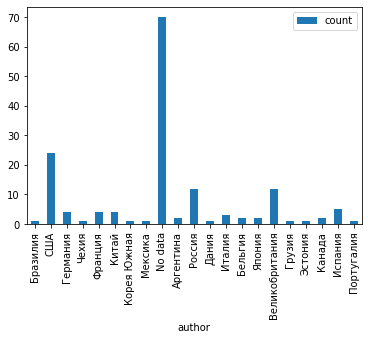

In [18]:
pandas_countries_df.plot.bar(x='author', y='count', rot=90)
plt.show()

In [19]:
from wordcloud import WordCloud, STOPWORDS

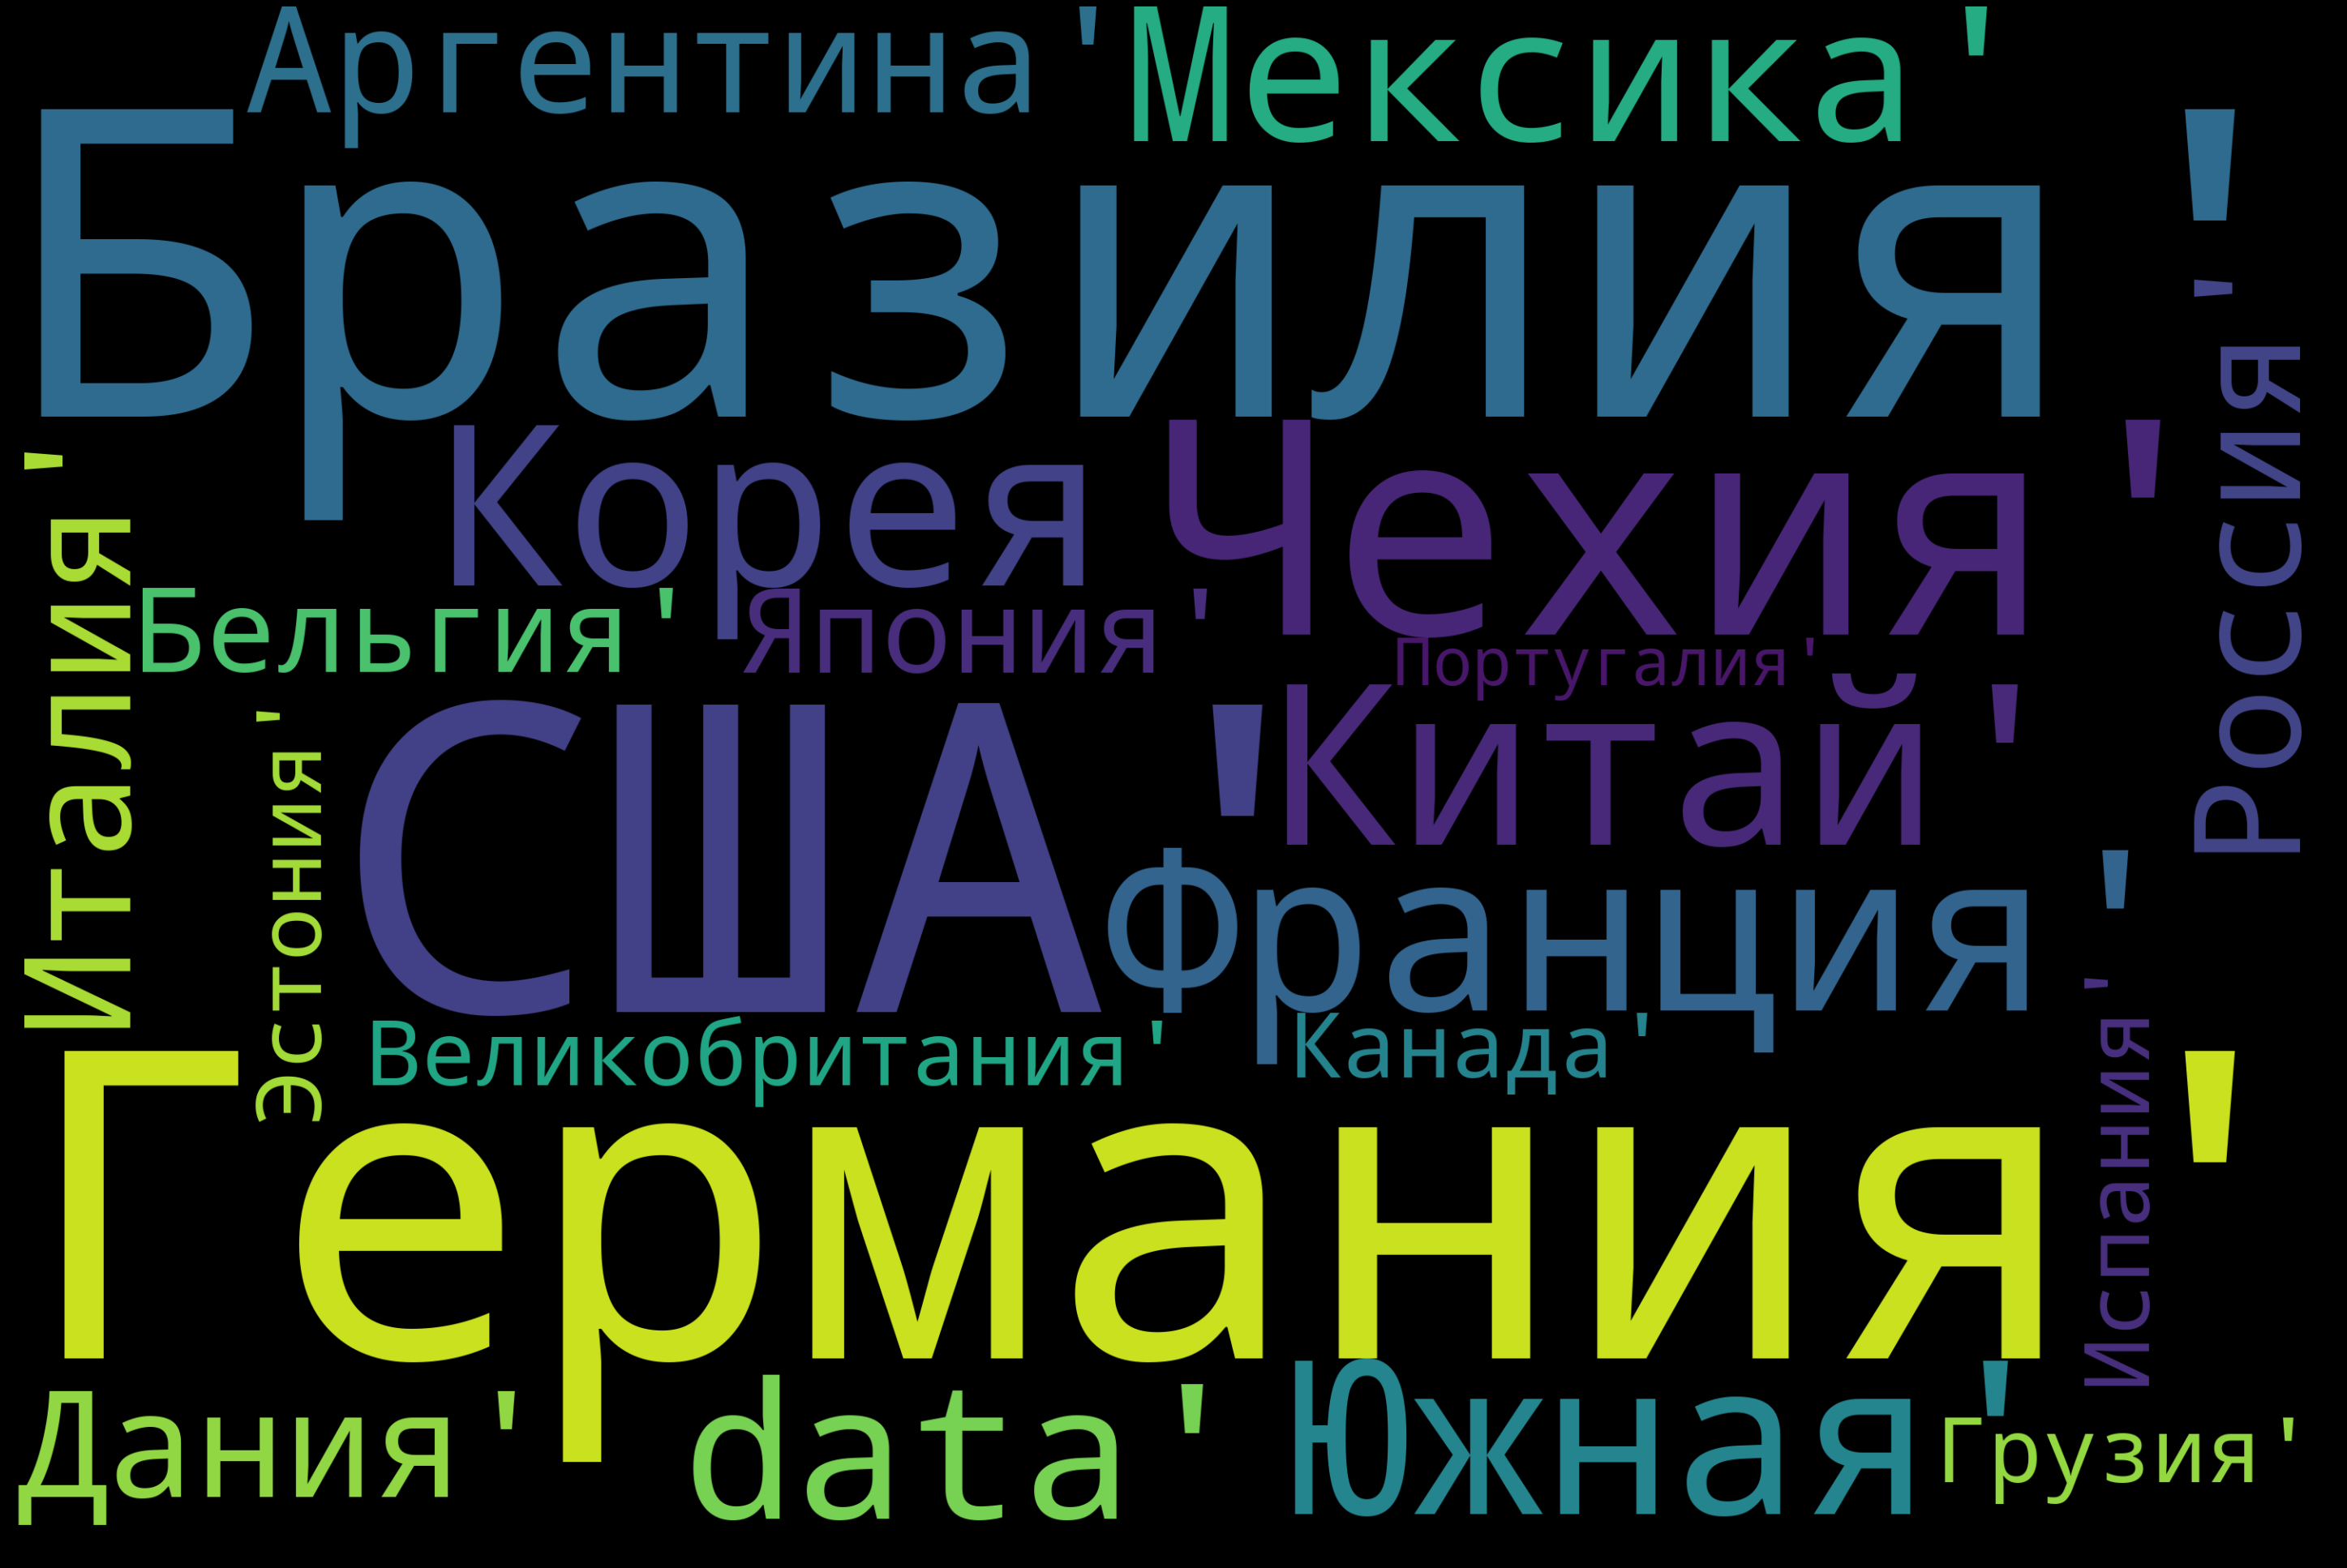

In [20]:
text = pandas_countries_df.author.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()